In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, expr, year, split, when, sum as spark_sum, row_number, lit, array, struct
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, MapType, ArrayType, BooleanType
from pyspark.sql.window import Window

import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

spark

Pour récuperer le schelma, d'abord chargé le json sans schema, et fais un printSchema()

In [0]:
# Définir le schéma du JSON
schema = StructType([
    StructField("id", StringType(), True),
    StructField("data", StructType([
        StructField("appid", IntegerType(), True),
        StructField("name", StringType(), True),
        StructField("short_description", StringType(), True),
        StructField("developer", StringType(), True),
        StructField("publisher", StringType(), True),
        StructField("genre", StringType(), True),
        StructField("tags", MapType(StringType(), IntegerType()), True),
        StructField("type", StringType(), True),
        StructField("categories", ArrayType(StringType()), True),
        StructField("owners", StringType(), True),
        StructField("positive", IntegerType(), True),
        StructField("negative", IntegerType(), True),
        StructField("price", StringType(), True),
        StructField("initialprice", StringType(), True),
        StructField("discount", StringType(), True),
        StructField("ccu", IntegerType(), True),
        StructField("languages", StringType(), True),
        StructField("platforms", MapType(StringType(), BooleanType()), True),
        StructField("release_date", StringType(), True),
        StructField("required_age", StringType(), True),
        StructField("website", StringType(), True),
        StructField("header_image", StringType(), True)
    ]), True)
])

In [0]:
# Charger le JSON en tant que DataFrame
df = spark.read.json("s3://full-stack-bigdata-datasets/Big_Data/Project_Steam/steam_game_output.json", schema)

# **Analysis at the "macro" level**

Which publisher has released the most games on Steam?

In [0]:
result = df.groupBy('data.publisher').count().orderBy('count', ascending=False)

result.show(5)

+--------------+-----+
|     publisher|count|
+--------------+-----+
|Big Fish Games|  422|
|        8floor|  202|
|          SEGA|  165|
|Strategy First|  151|
|   Square Enix|  141|
+--------------+-----+
only showing top 5 rows



What are the best rated games?

In [0]:
result = df.select(
  col('data.name'),
  col('data.positive')
  ).orderBy('data.positive', ascending=False)

result.show(5)

+--------------------+--------+
|                name|positive|
+--------------------+--------+
|Counter-Strike: G...| 5943345|
|              Dota 2| 1534895|
|  Grand Theft Auto V| 1229265|
| PUBG: BATTLEGROUNDS| 1185361|
|            Terraria| 1014711|
+--------------------+--------+
only showing top 5 rows



Are there years with more releases? Were there more or fewer game releases during the Covid, for example?

In [0]:
df_year = df.withColumn("year", split(df['data.release_date'], '/').getItem(0))

result = df_year.groupBy('year').count().orderBy('count', ascending=False)

result.show(10)

+----+-----+
|year|count|
+----+-----+
|2021| 8823|
|2020| 8305|
|2018| 7678|
|2022| 7455|
|2019| 6968|
|2017| 6017|
|2016| 4185|
|2015| 2576|
|2014| 1557|
|2013|  471|
+----+-----+
only showing top 10 rows



In [0]:
result.count()

27

How are the prizes distributed? Are there many games with a discount?

In [0]:
df_price = df.select(
    col("data.name"),
    col("data.price"),
    col("data.initialprice"),
    col("data.discount")
)

# Afficher le DataFrame
df_price.show(10, truncate=False, vertical=False)

+------------------------------------+-----+------------+--------+
|name                                |price|initialprice|discount|
+------------------------------------+-----+------------+--------+
|Counter-Strike                      |999  |999         |0       |
|ASCENXION                           |999  |999         |0       |
|Crown Trick                         |599  |1999        |70      |
|Cook, Serve, Delicious! 3?!         |1999 |1999        |0       |
|细胞战争                            |199  |199         |0       |
|Zengeon                             |799  |1999        |60      |
|干支セトラ　陽ノ卷｜干支etc.　陽之卷|1299 |1299        |0       |
|Jumping Master(跳跳大咖)            |0    |0           |0       |
|Cube Defender                       |299  |299         |0       |
|Tower of Origin2-Worm's Nest        |1399 |1399        |0       |
+------------------------------------+-----+------------+--------+
only showing top 10 rows



In [0]:
df_price = df_price.withColumn('price', df_price.price.cast(IntegerType()))
df_price = df_price \
    .withColumn('formatted_price', df_price.price / 100) \
    .withColumn('has_discount', when(df_price['discount'] > 0, 1).otherwise(0))

result = df_price.orderBy('price', ascending=False)

result.show(10)

+--------------------+-----+------------+--------+---------------+------------+
|                name|price|initialprice|discount|formatted_price|has_discount|
+--------------------+-----+------------+--------+---------------+------------+
|Ascent Free-Roami...|99900|       99900|       0|          999.0|           0|
|Aartform Curvy 3D...|29990|       29990|       0|          299.9|           0|
|       Houdini Indie|26999|       26999|       0|         269.99|           0|
|VEGAS Edit 20 Ste...|24900|       24900|       0|          249.0|           0|
|The Island of Dr....|19999|       19999|       0|         199.99|           0|
|      Virtual Orator|19999|       19999|       0|         199.99|           0|
|      Chandrayaan VR|19999|       19999|       0|         199.99|           0|
|        Arcade Drift|19999|       19999|       0|         199.99|           0|
|           Run Thief|19999|       19999|       0|         199.99|           0|
|               fight|19999|       19999

In [0]:
df_price_pd = df_price.toPandas()

fig = px.box(df_price_pd, y = 'formatted_price', width = 800)
fig.show()

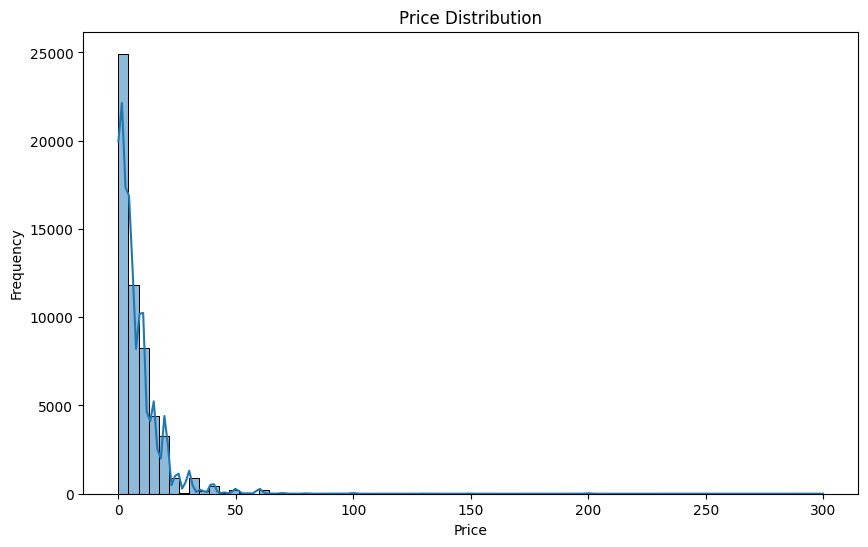

In [0]:
# Suppression d'un outlier
df_price_pd = df_price_pd[df_price_pd['price'] != 99900]

plt.figure(figsize=(10, 6))
sns.histplot(df_price_pd['formatted_price'], bins=70, kde=True)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution')
plt.show()

In [0]:
result = df_price.groupBy('has_discount').count().orderBy('count')

result.show(10)

+------------+-----+
|has_discount|count|
+------------+-----+
|           1| 2518|
|           0|53173|
+------------+-----+



What are the most represented languages?

In [0]:
df_languages = df.select(
    col("id"),
    explode(split(col("data.languages"), ", ")).alias("languages")
)

df_languages.show(10)

+-------+-------------------+
|     id|          languages|
+-------+-------------------+
|     10|            English|
|     10|             French|
|     10|             German|
|     10|            Italian|
|     10|    Spanish - Spain|
|     10| Simplified Chinese|
|     10|Traditional Chinese|
|     10|             Korean|
|1000000|            English|
|1000000|             Korean|
+-------+-------------------+
only showing top 10 rows



In [0]:
result = df_languages.groupBy('languages').count().orderBy('count', ascending=False)

result.show(10)

+-------------------+-----+
|          languages|count|
+-------------------+-----+
|            English|55116|
|             German|14019|
|             French|13426|
|            Russian|12922|
| Simplified Chinese|12782|
|    Spanish - Spain|12233|
|           Japanese|10368|
|            Italian| 9304|
|Portuguese - Brazil| 6750|
|             Korean| 6599|
+-------------------+-----+
only showing top 10 rows



Are there many games prohibited for children under 16/18?

In [0]:
df_ages = df.select(
    col("id"),
    col("data.name"),
    col("data.required_age")
)

df_ages.select("required_age").distinct().show(25)

+------------+
|required_age|
+------------+
|           7|
|          15|
|           3|
|           8|
|          16|
|          35|
|           0|
|         21+|
|           5|
|          18|
|          17|
|           6|
|         180|
|           9|
|          7+|
|          20|
|          10|
|          12|
|          13|
|          14|
|      MA 15+|
+------------+



In [0]:
df_ages = df_ages.withColumn("required_age_int",
                   when(col("required_age") == 'MA 15+', 15) \
                       .when(col("required_age") == '21+', 21) \
                       .when(col("required_age") == '7+', 7) \
                       .otherwise(col("required_age").cast('int')))

# 0 Sous 16 ans
# 1 Au dessus de 16 ans
df_ages = df_ages.withColumn("age_category",
                   when(col("required_age_int") >= 16, 1).otherwise(0))

df_ages.groupBy('age_category').count().orderBy('count', ascending=False).show()

+------------+-----+
|age_category|count|
+------------+-----+
|           0|55385|
|           1|  306|
+------------+-----+



# **Genres analysis**

What are the most represented genres?

In [0]:
df_genres = df.select(
    col("id"),
    explode(split(col("data.genre"), ", ")).alias("genre")
)

result = df_genres.groupBy('genre').count().orderBy('count', ascending=False)

result.show()

+--------------------+-----+
|               genre|count|
+--------------------+-----+
|               Indie|39681|
|              Action|23759|
|              Casual|22086|
|           Adventure|21431|
|            Strategy|10895|
|          Simulation|10836|
|                 RPG| 9534|
|        Early Access| 6145|
|        Free to Play| 3393|
|              Sports| 2666|
|              Racing| 2155|
|Massively Multipl...| 1460|
|           Utilities|  682|
|Design & Illustra...|  406|
|Animation & Modeling|  322|
|           Education|  317|
|    Video Production|  247|
|    Audio Production|  195|
|             Violent|  168|
|   Software Training|  164|
+--------------------+-----+
only showing top 20 rows



Are there any genres that have a better positive/negative review ratio?

In [0]:
df_ratio = df.select(
    col("id"),
    col("data.negative"),
    col("data.positive"),
    explode(split(col("data.genre"), ", ")).alias("genre")
)

df_ratio.show()

+-------+--------+--------+----------+
|     id|negative|positive|     genre|
+-------+--------+--------+----------+
|     10|    5199|  201215|    Action|
|1000000|       5|      27|    Action|
|1000000|       5|      27| Adventure|
|1000000|       5|      27|     Indie|
|1000010|     646|    4032| Adventure|
|1000010|     646|    4032|     Indie|
|1000010|     646|    4032|       RPG|
|1000010|     646|    4032|  Strategy|
|1000030|     115|    1575|    Action|
|1000030|     115|    1575|     Indie|
|1000030|     115|    1575|Simulation|
|1000030|     115|    1575|  Strategy|
|1000040|       1|       0|    Action|
|1000040|       1|       0|    Casual|
|1000040|       1|       0|     Indie|
|1000040|       1|       0|Simulation|
|1000080|     462|    1018|    Action|
|1000080|     462|    1018| Adventure|
|1000080|     462|    1018|     Indie|
|1000080|     462|    1018|       RPG|
+-------+--------+--------+----------+
only showing top 20 rows



In [0]:
result = df_ratio.groupBy("genre").agg(
    (100 * spark_sum("positive") / (spark_sum("negative") + spark_sum("positive"))).alias("ratio")
).orderBy('ratio', ascending=False)

result.show()

+--------------------+-----------------+
|               genre|            ratio|
+--------------------+-----------------+
|       Photo Editing|97.67623111567957|
|Animation & Modeling|96.31991321286692|
|Design & Illustra...|96.14771261967523|
|           Utilities|94.44291156024619|
|    Game Development|89.34764925980153|
|               Indie|88.46621244923857|
|    Audio Production|87.99684261451888|
|                    |87.23785954469555|
|    Video Production|87.20479214238794|
|              Casual|86.71568387272221|
|      Web Publishing|86.64525011473152|
|          Simulation|86.64371507728691|
|              Racing|  85.914654829364|
|                 RPG| 85.5755560740121|
|              Action|84.99114209174296|
|            Strategy|84.84818750219593|
|           Adventure| 84.0047044645671|
|        Early Access|82.23811401183808|
|                Gore|81.60483618010208|
|        Free to Play|81.39026589209702|
+--------------------+-----------------+
only showing top

Do some publishers have favorite genres?

In [0]:
df_favorite = df.select(
    col("data.publisher"),
    explode(split(col("data.genre"), ", ")).alias("genre")
)

In [0]:
result = df_favorite.groupBy('publisher', 'genre').count().orderBy('count', ascending=False)

result.show()

+--------------------+---------+-----+
|           publisher|    genre|count|
+--------------------+---------+-----+
|      Big Fish Games|   Casual|  418|
|      Big Fish Games|Adventure|  392|
|              8floor|   Casual|  202|
|     Choice of Games|      RPG|  139|
|     Choice of Games|    Indie|  136|
|            HH-Games|   Casual|  132|
|        Laush Studio|    Indie|  124|
|     Choice of Games|Adventure|  112|
|                    |    Indie|  106|
|Alawar Entertainment|   Casual|  105|
|       Sekai Project|   Casual|   99|
|   Sokpop Collective|    Indie|   97|
|     Slitherine Ltd.| Strategy|   96|
|Alawar Entertainment|Adventure|   95|
|      Reforged Group|    Indie|   88|
|       Sekai Project|    Indie|   88|
|        Laush Studio|   Casual|   87|
|    Devolver Digital|    Indie|   87|
|             PLAYISM|    Indie|   81|
|                SEGA|   Action|   80|
+--------------------+---------+-----+
only showing top 20 rows



In [0]:
# Créer une fenêtre pour partitionner par 'publisher' et trier par 'count'
window_spec = Window.partitionBy("publisher").orderBy(col("count").desc())

# Ajouter une colonne 'row_number' pour identifier le plus grand 'count' par 'publisher'
result_with_row_number = result.withColumn("row_number", row_number().over(window_spec))

# Filtrer pour ne garder que la première ligne (le plus grand 'count') par 'publisher'
result2 = result_with_row_number.filter(col("row_number") == 1).drop("row_number")

# Afficher le résultat
result2.orderBy('count', ascending=False).show()

+--------------------+--------+-----+
|           publisher|   genre|count|
+--------------------+--------+-----+
|      Big Fish Games|  Casual|  418|
|              8floor|  Casual|  202|
|     Choice of Games|     RPG|  139|
|            HH-Games|  Casual|  132|
|        Laush Studio|   Indie|  124|
|                    |   Indie|  106|
|Alawar Entertainment|  Casual|  105|
|       Sekai Project|  Casual|   99|
|   Sokpop Collective|   Indie|   97|
|     Slitherine Ltd.|Strategy|   96|
|      Reforged Group|   Indie|   88|
|    Devolver Digital|   Indie|   87|
|             PLAYISM|   Indie|   81|
|                SEGA|  Action|   80|
|     Plug In Digital|   Indie|   79|
|        Hosted Games|     RPG|   79|
|      Piece Of Voxel|   Indie|   79|
|        Kagura Games|     RPG|   78|
|  Boogygames Studios|   Indie|   78|
|         SA Industry|   Indie|   76|
+--------------------+--------+-----+
only showing top 20 rows



What are the most lucrative genres?

In [0]:
df_genre_ccu = df.select(
    explode(split(col("data.genre"), ", ")).alias("genre"),
    col("data.ccu")
)

In [0]:
df_genre_ccu.show(2)

+------+-----+
| genre|  ccu|
+------+-----+
|Action|13990|
|Action|    0|
+------+-----+
only showing top 2 rows



In [0]:
result = df_genre_ccu.groupBy('genre') \
    .sum('ccu') \
    .withColumnRenamed('sum(ccu)', 'sum_ccu')

In [0]:
result.orderBy('sum_ccu', ascending=False).show()

+--------------------+-------+
|               genre|sum_ccu|
+--------------------+-------+
|              Action|5678539|
|        Free to Play|3421794|
|           Adventure|2723049|
|            Strategy|1915281|
|                 RPG|1775671|
|               Indie|1753417|
|Massively Multipl...|1599723|
|          Simulation|1508269|
|              Casual| 618172|
|        Early Access| 412959|
|              Sports| 359495|
|           Utilities| 153948|
|Animation & Modeling| 140566|
|              Racing| 136837|
|Design & Illustra...| 133169|
|       Photo Editing| 112568|
|    Video Production|  24174|
|    Audio Production|  18484|
|   Software Training|   7057|
|           Education|   6945|
+--------------------+-------+
only showing top 20 rows



# **Platform analysis**

Are most games available on Windows/Mac/Linux instead?

In [0]:
df_platform = df \
    .withColumn("windows", when(col("data.platforms.windows"), 1).otherwise(0)) \
    .withColumn("mac", when(col("data.platforms.mac"), 1).otherwise(0)) \
    .withColumn("linux", when(col("data.platforms.linux"), 1).otherwise(0)) \
    .drop('data', 'id') \
    .agg(
        spark_sum("windows").alias("total_windows"),
        spark_sum("mac").alias("total_mac"),
        spark_sum("linux").alias("total_linux")
)

In [0]:
df_platform.show()

+-------------+---------+-----------+
|total_windows|total_mac|total_linux|
+-------------+---------+-----------+
|        55676|    12770|       8458|
+-------------+---------+-----------+



In [0]:
# Transformer les colonnes en lignes
result = df_platform.select(
    explode(
        array(
            struct(lit("total_windows").alias("metric"), col("total_windows").alias("value")),
            struct(lit("total_mac").alias("metric"), col("total_mac").alias("value")),
            struct(lit("total_linux").alias("metric"), col("total_linux").alias("value"))
        )
    ).alias("melted")
).select("melted.metric", "melted.value")

In [0]:
display(result)

metric,value
total_windows,55676
total_mac,12770
total_linux,8458


Databricks visualization. Run in Databricks to view.

Do certain genres tend to be preferentially available on certain platforms?

In [0]:
df_genre_platforms = df \
    .withColumn('genre', explode(split(col("data.genre"), ", "))) \
    .withColumn("windows", when(col("data.platforms.windows"), 1).otherwise(0)) \
    .withColumn("mac", when(col("data.platforms.mac"), 1).otherwise(0)) \
    .withColumn("linux", when(col("data.platforms.linux"), 1).otherwise(0)) \
    .drop('data', 'id') \
    .groupBy('genre') \
    .sum()

In [0]:
display(df_genre_platforms)

genre,sum(windows),sum(mac),sum(linux)
Education,317,56,19
Massively Multiplayer,1459,270,164
Sexual Content,54,13,7
Adventure,21427,5039,3302
Sports,2665,506,287
Accounting,16,4,0
Audio Production,193,41,7
Video Production,247,29,6
Animation & Modeling,322,74,38
Racing,2154,424,304


Databricks visualization. Run in Databricks to view.